In [1]:
import os
import findspark
findspark.init()
import pyspark
from pyspark import SQLContext
sc = pyspark.SparkContext(master='spark://192.168.11.239:7077', appName='preprocess_growth')

In [11]:
from pyspark.sql.types import *
sqlContext = SQLContext(sc)
from datetime import datetime
import pyspark.sql.functions as F
import matplotlib
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = sqlContext.read.csv("/datasets/crimes.csv", header='true')
df.count()

7063815

In [4]:
df.agg(F.countDistinct(F.col("Beat")).alias("count")).show()

+-----+
|count|
+-----+
|  304|
+-----+



In [5]:
df.agg(F.countDistinct(F.col("District")).alias("count")).show()

+-----+
|count|
+-----+
|   24|
+-----+



Since there are 304 Beats, lets analyse the districts instead

In [4]:
df = (df
       .withColumn('Timestamps', F.to_timestamp("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn('Day', F.to_date("Date", 'MM/dd/yyyy hh:mm:ss a'))
       .withColumn("Month", F.month("Day"))
       .withColumn("Hour", F.hour("Timestamps"))
       .withColumn("DayOfMonth", F.dayofmonth("Day"))
       .withColumn("DayOfWeek", F.dayofweek("Day"))
      )

## Daily crime trend

Moving average smoothing

In [5]:
daily = df.groupBy("Day").count().sort(F.col("Day"))
daily.count()

6969

In [6]:
w = Window.orderBy("Day").rowsBetween(-7,0)
daily = daily.withColumn('7-MA', F.avg("count").over(w))
daily.show(5)

+----------+-----+-------+
|       Day|count|   7-MA|
+----------+-----+-------+
|2001-01-01| 1819| 1819.0|
|2001-01-02| 1143| 1481.0|
|2001-01-03| 1151| 1371.0|
|2001-01-04| 1166|1319.75|
|2001-01-05| 1267| 1309.2|
+----------+-----+-------+
only showing top 5 rows



In [7]:
df_daily = daily.toPandas().sort_values(by = "Day").set_index('Day')

In [8]:
df_daily.rename(columns={"count": "Daily"},inplace=True)

Next, apply Moving average smoothing in order to remove some randomness
https://stackoverflow.com/questions/45806194/pyspark-rolling-average-using-timeseries-data

<Figure size 432x288 with 0 Axes>

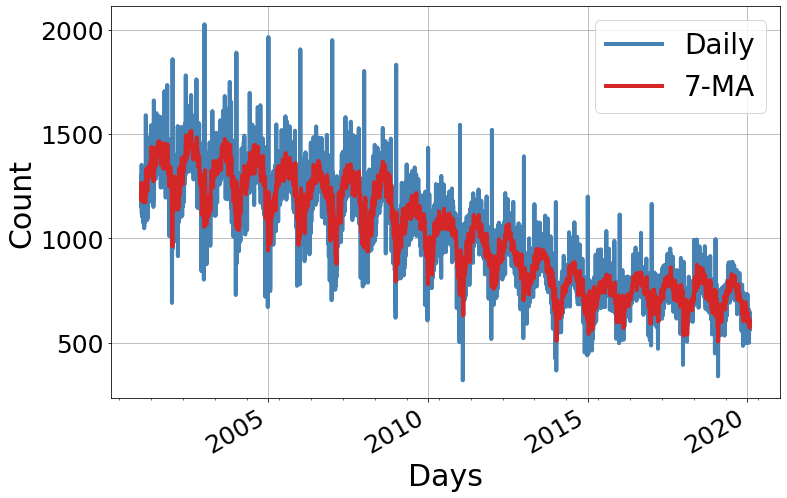

In [18]:
plt.clf()
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(111)

reg = df_daily[7:]["Daily"]
ma = df_daily[7:]["7-MA"]

ax.plot(reg.index, reg.values, linewidth=4, label="Daily",c='steelblue')
ax.plot(ma.index, ma.values, linewidth=4, label="7-MA",c='C3')

years = matplotlib.dates.YearLocator(5)   
months = matplotlib.dates.MonthLocator(5)  
years_fmt = matplotlib.dates.DateFormatter('%Y')


ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)

ax.format_xdata = matplotlib.dates.DateFormatter('%Y-%m-%d')
ax.grid(True)
plt.locator_params(axis='y', nbins=5)
fig.autofmt_xdate()
plt.xlabel('Days', fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=28, loc='upper right')
plt.savefig('daily_window_avg.png')
plt.show()

#### Daily count per district
Lets see how the daily count has changed over time per district. In order to do that, we have to group by and count per district, and then create a pivot table with each district value as an own column.

In [19]:
daily_dist = (df\
            .groupBy("Day","District")\
            .count()\
            .groupBy("Day")\
            .pivot("District")\
            .agg({'count':'max'})\
            .drop("District","null")\
            .orderBy('Day'))
daily_dist.show(5)

+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+
|       Day|001|002|003|004|005|006|007|008|009|010|011|012|014|015|016|017|018|019|020| 021|022|024|025| 031|
+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+
|2001-01-01| 38|110|103| 97| 95| 84| 83|112|109|104| 90| 81| 83| 71| 67| 67| 72| 72| 40|null| 61| 59|121|null|
|2001-01-02| 44| 93| 57| 49| 42| 62| 64| 69| 55| 49| 64| 60| 52| 58| 40| 21| 54| 54| 27|null| 35| 44| 50|null|
|2001-01-03| 44| 89| 57| 49| 39| 48| 56| 73| 54| 46| 64| 59| 51| 68| 48| 40| 46| 50| 20|null| 37| 46| 67|null|
|2001-01-04| 41| 87| 45| 73| 51| 85| 52| 78| 47| 43| 62| 68| 53| 45| 42| 36| 54| 46| 14|null| 46| 41| 57|null|
|2001-01-05| 67| 99| 62| 56| 48| 65| 67| 81| 55| 45| 70| 68| 59| 68| 49| 34| 56| 48| 25|null| 39| 45| 61|null|
+----------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+----+
o

In order to plot these district counts, we have to perform moving average smoothing on each column. In this case, perform 30-MA since the subplots is quite small

In [20]:
daily_dist_cols = daily_dist.schema.names
if "Day" in daily_dist_cols:
    daily_dist_cols.remove("Day")

In [21]:
MA_30 = Window.orderBy("Day").rowsBetween(-30,0)
daily_dist_MA = daily_dist
for dist in daily_dist_cols:
    daily_dist_MA = daily_dist_MA.withColumn(dist +'_30-MA', F.avg(dist).over(MA_30))

daily_dist_MA = daily_dist_MA.drop(*daily_dist_cols)

In [22]:
df_daily_dist = daily_dist_MA.toPandas().set_index('Day')
df_daily_dist.head()

,001_30-MA,002_30-MA,003_30-MA,004_30-MA,005_30-MA,006_30-MA,007_30-MA,008_30-MA,009_30-MA,010_30-MA,...,016_30-MA,017_30-MA,018_30-MA,019_30-MA,020_30-MA,021_30-MA,022_30-MA,024_30-MA,025_30-MA,031_30-MA
Day,,,,,,,,,,,,,,,,,,,,,
2001-01-01,38.00,110.000000,103.000000,97.0,95.000000,84.000000,83.000000,112.000000,109.000000,104.000000,...,67.000000,67.000000,72.000000,72.000000,40.00,NaN,61.000000,59.000000,121.000000,NaN
2001-01-02,41.00,101.500000,80.000000,73.0,68.500000,73.000000,73.500000,90.500000,82.000000,76.500000,...,53.500000,44.000000,63.000000,63.000000,33.50,NaN,48.000000,51.500000,85.500000,NaN
2001-01-03,42.00,97.333333,72.333333,65.0,58.666667,64.666667,67.666667,84.666667,72.666667,66.333333,...,51.666667,42.666667,57.333333,58.666667,29.00,NaN,44.333333,49.666667,79.333333,NaN
2001-01-04,41.75,94.750000,65.500000,67.0,56.750000,69.750000,63.750000,83.000000,66.250000,60.500000,...,49.250000,41.000000,56.500000,55.500000,25.25,NaN,44.750000,47.500000,73.750000,NaN
2001-01-05,46.80,95.600000,64.800000,64.8,55.000000,68.800000,64.400000,82.600000,64.000000,57.400000,...,49.200000,39.600000,56.400000,54.000000,25.20,NaN,43.600000,47.000000,71.200000,NaN


<Figure size 432x288 with 0 Axes>

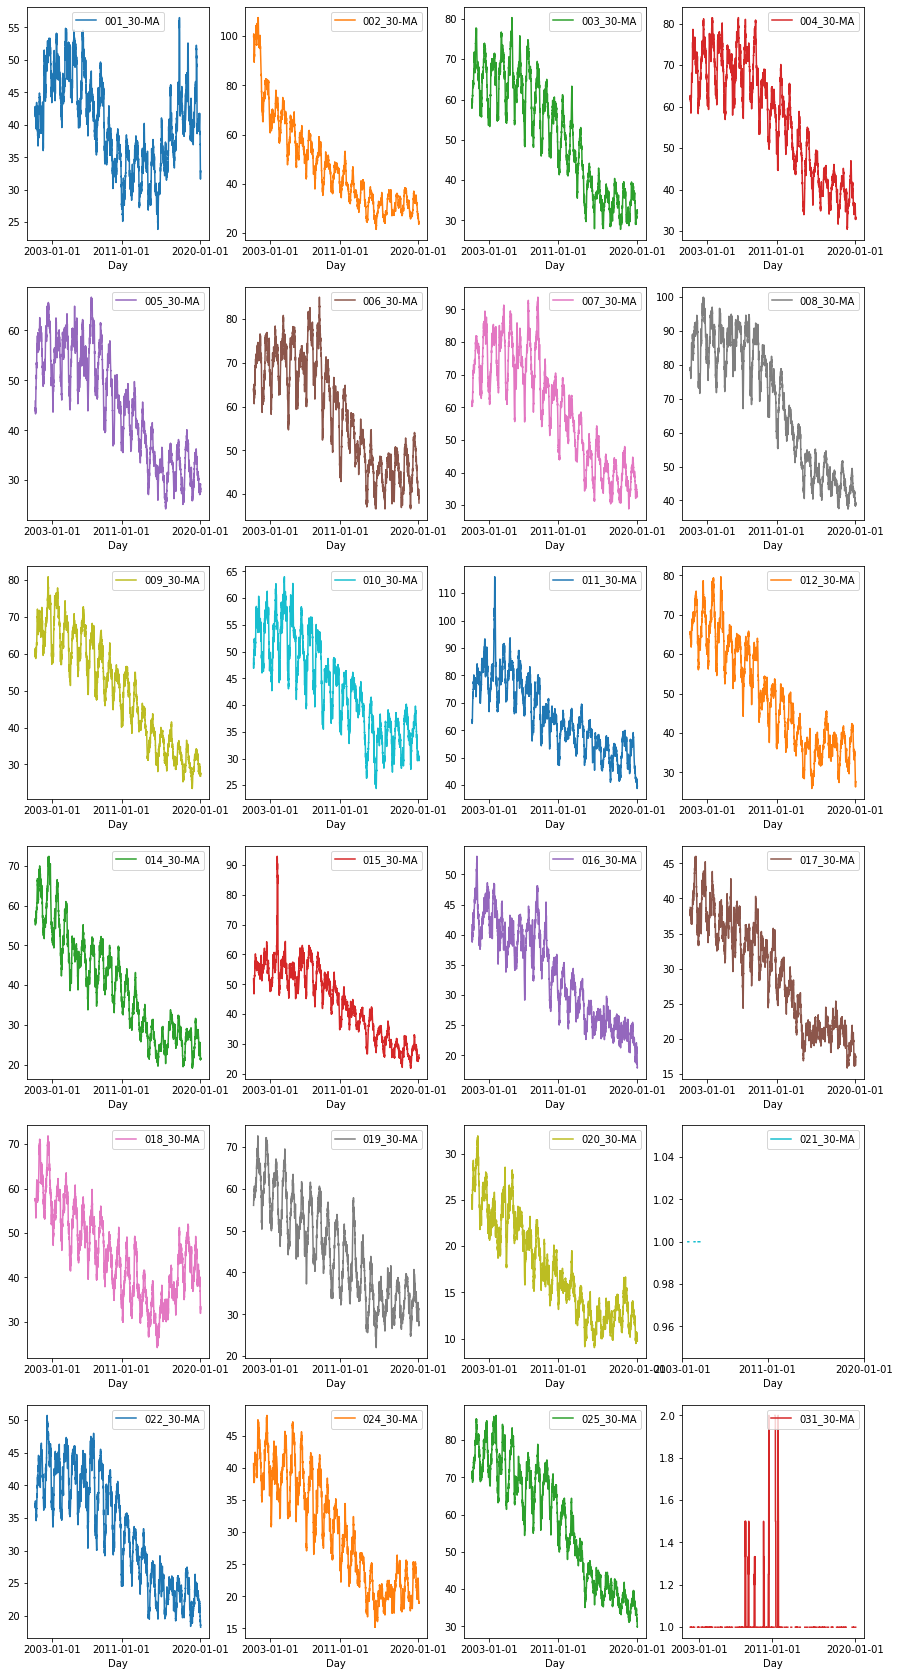

In [24]:
plt.clf()
df_daily_dist[30:].plot(figsize=(15, 30),
                   subplots=True,
                   layout=(-1, 4),
                   sharex=False,
                   sharey=False,
                   xticks=["2003","2011","2020"])

plt.show()

We can see that most districts follow a descending growth, however district 024, 018 and 001 has experienced a rise of crime over that past few years again. District 031 and 021 does not have sufficient amount of data to be concidered.

## Monthly crime trend

In this section, we are going to look at how the crime rate has changed month for month from 2001-2020. It will help us to find seasonal patterns and overall trends

In [111]:
monthly = df.groupBy("year","Month").count().sort(F.col("year"))
monthly.show()

+----+-----+-----+
|year|Month|count|
+----+-----+-----+
|2001|    9|41504|
|2001|   10|43029|
|2001|    6|41725|
|2001|    2|33779|
|2001|    4|40082|
|2001|    1|38103|
|2001|   11|39597|
|2001|    5|41822|
|2001|    3|40552|
|2001|    7|44692|
|2001|   12|36846|
|2001|    8|44032|
|2002|    8|44210|
|2002|   12|37172|
|2002|    1|38406|
|2002|   10|43144|
|2002|    9|42388|
|2002|    6|42835|
|2002|    4|40035|
|2002|    2|33909|
+----+-----+-----+
only showing top 20 rows



In [112]:
monthly_piv =(monthly\
             .groupBy("year")\
             .pivot("Month")\
             .agg({"count":"max"})\
             .orderBy('year'))

monthly_piv.show(5)

+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|year|    1|    2|    3|    4|    5|    6|    7|    8|    9|   10|   11|   12|
+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|2001|38103|33779|40552|40082|41822|41725|44692|44032|41504|43029|39597|36846|
|2002|38406|33909|38585|40035|42913|42835|46013|44210|42388|43144|37152|37172|
|2003|36715|32509|38650|39789|41193|40815|43415|44269|41423|43327|38056|35791|
|2004|35106|34066|39855|38269|40779|41134|43237|43044|41213|41523|36841|34323|
|2005|33861|31986|36905|38871|40468|40050|41806|41543|39623|39961|35977|32669|
|2006|36755|31298|36984|36476|39615|38814|41549|40496|37772|38661|35569|34140|
|2007|34105|27136|36350|35634|40088|38994|40989|39849|38265|39591|34423|31609|
|2008|33368|29047|33977|35593|38063|37698|40491|40539|37445|37887|33559|29413|
|2009|30250|28231|33688|32567|35245|34272|35675|35830|33871|33534|31390|28186|
|2010|29222|24945|32336|31670|33403|32715|33511|3415

In [113]:
df_monthly = monthly_piv.toPandas().set_index('year')
df_monthly.head()

,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2001,38103,33779.0,40552.0,40082.0,41822.0,41725.0,44692.0,44032.0,41504.0,43029.0,39597.0,36846.0
2002,38406,33909.0,38585.0,40035.0,42913.0,42835.0,46013.0,44210.0,42388.0,43144.0,37152.0,37172.0
2003,36715,32509.0,38650.0,39789.0,41193.0,40815.0,43415.0,44269.0,41423.0,43327.0,38056.0,35791.0
2004,35106,34066.0,39855.0,38269.0,40779.0,41134.0,43237.0,43044.0,41213.0,41523.0,36841.0,34323.0
2005,33861,31986.0,36905.0,38871.0,40468.0,40050.0,41806.0,41543.0,39623.0,39961.0,35977.0,32669.0


In [8]:
#Taken from http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
tableau_20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

#Scale RGB between 0 and 1, so matplotlib accepts it    
for i in range(len(tableau_20)):    
    r, g, b = tableau_20[i]    
    tableau_20[i] = (r / 255., g / 255., b / 255.) 

/home/ubuntu/anaconda3/envs/dat500/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<Figure size 432x288 with 0 Axes>

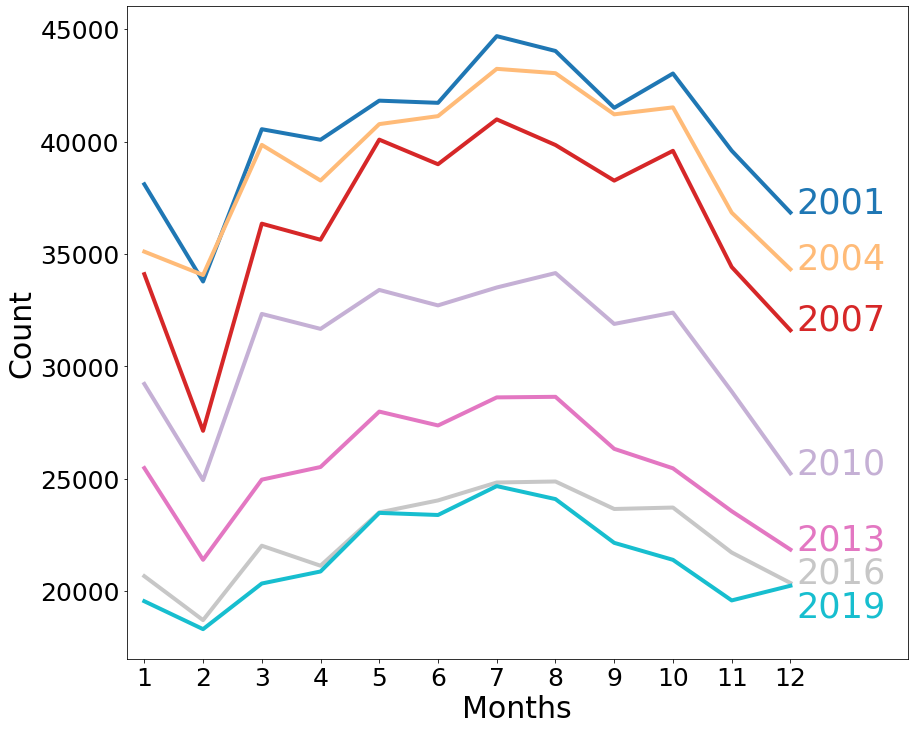

In [183]:
plt.clf()
plt.figure(figsize=(14, 12)) 
plt.xticks(np.arange(1,13))
  
ax = plt.subplot(111)    
plt.xlim(.7, 14) 

i=0
for idx,r in df_monthly.iterrows():
    if i%3==0 and int(idx) != 2020:    
        plt.plot(np.arange(1,13), r.values, color=tableau_20[i],linewidth=4)
        _y = int(r[11])
        if int(idx) == 2019:
            _y = _y - 1400

        plt.text(x=12.1,y=_y,s=str(idx),color=tableau_20[i],fontsize=35)
    i+=1

plt.xlabel('Months', fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('monthly_trend.png')
plt.show()

#### Monthly count per district

In [20]:
month_dist = (df\
            .groupBy("Month","year","District")\
            .count()\
            .groupBy("year","month")\
            .pivot("District")\
            .agg({'count':'max'})\
            .drop("District","null")\
            .orderBy('year','month'))

In [21]:
df_monthly_dist = month_dist.toPandas().set_index('year')
df_monthly_dist.head()

,month,001,002,003,004,005,006,007,008,009,...,016,017,018,019,020,021,022,024,025,031
year,,,,,,,,,,,,,,,,,,,,,
2001,1,1298,3096,1832,1940,1422,1980,1890,2441,1882,...,1291,1200,1787,1737,792,NaN,1153,1262,2212,NaN
2001,2,1120,2534,1713,1621,1336,1753,1757,2159,1662,...,1117,1027,1511,1635,729,NaN,1007,1075,1917,NaN
2001,3,1332,3099,2000,2108,1641,2089,2198,2672,1957,...,1328,1190,1897,1859,902,NaN,1131,1276,2267,NaN
2001,4,1207,3040,2052,2067,1741,2075,2145,2580,2120,...,1283,1151,1722,1833,786,NaN,1194,1229,2235,NaN
2001,5,1174,3075,2140,2348,1765,2211,2298,2571,2069,...,1413,1224,1859,1946,833,NaN,1312,1259,2311,NaN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


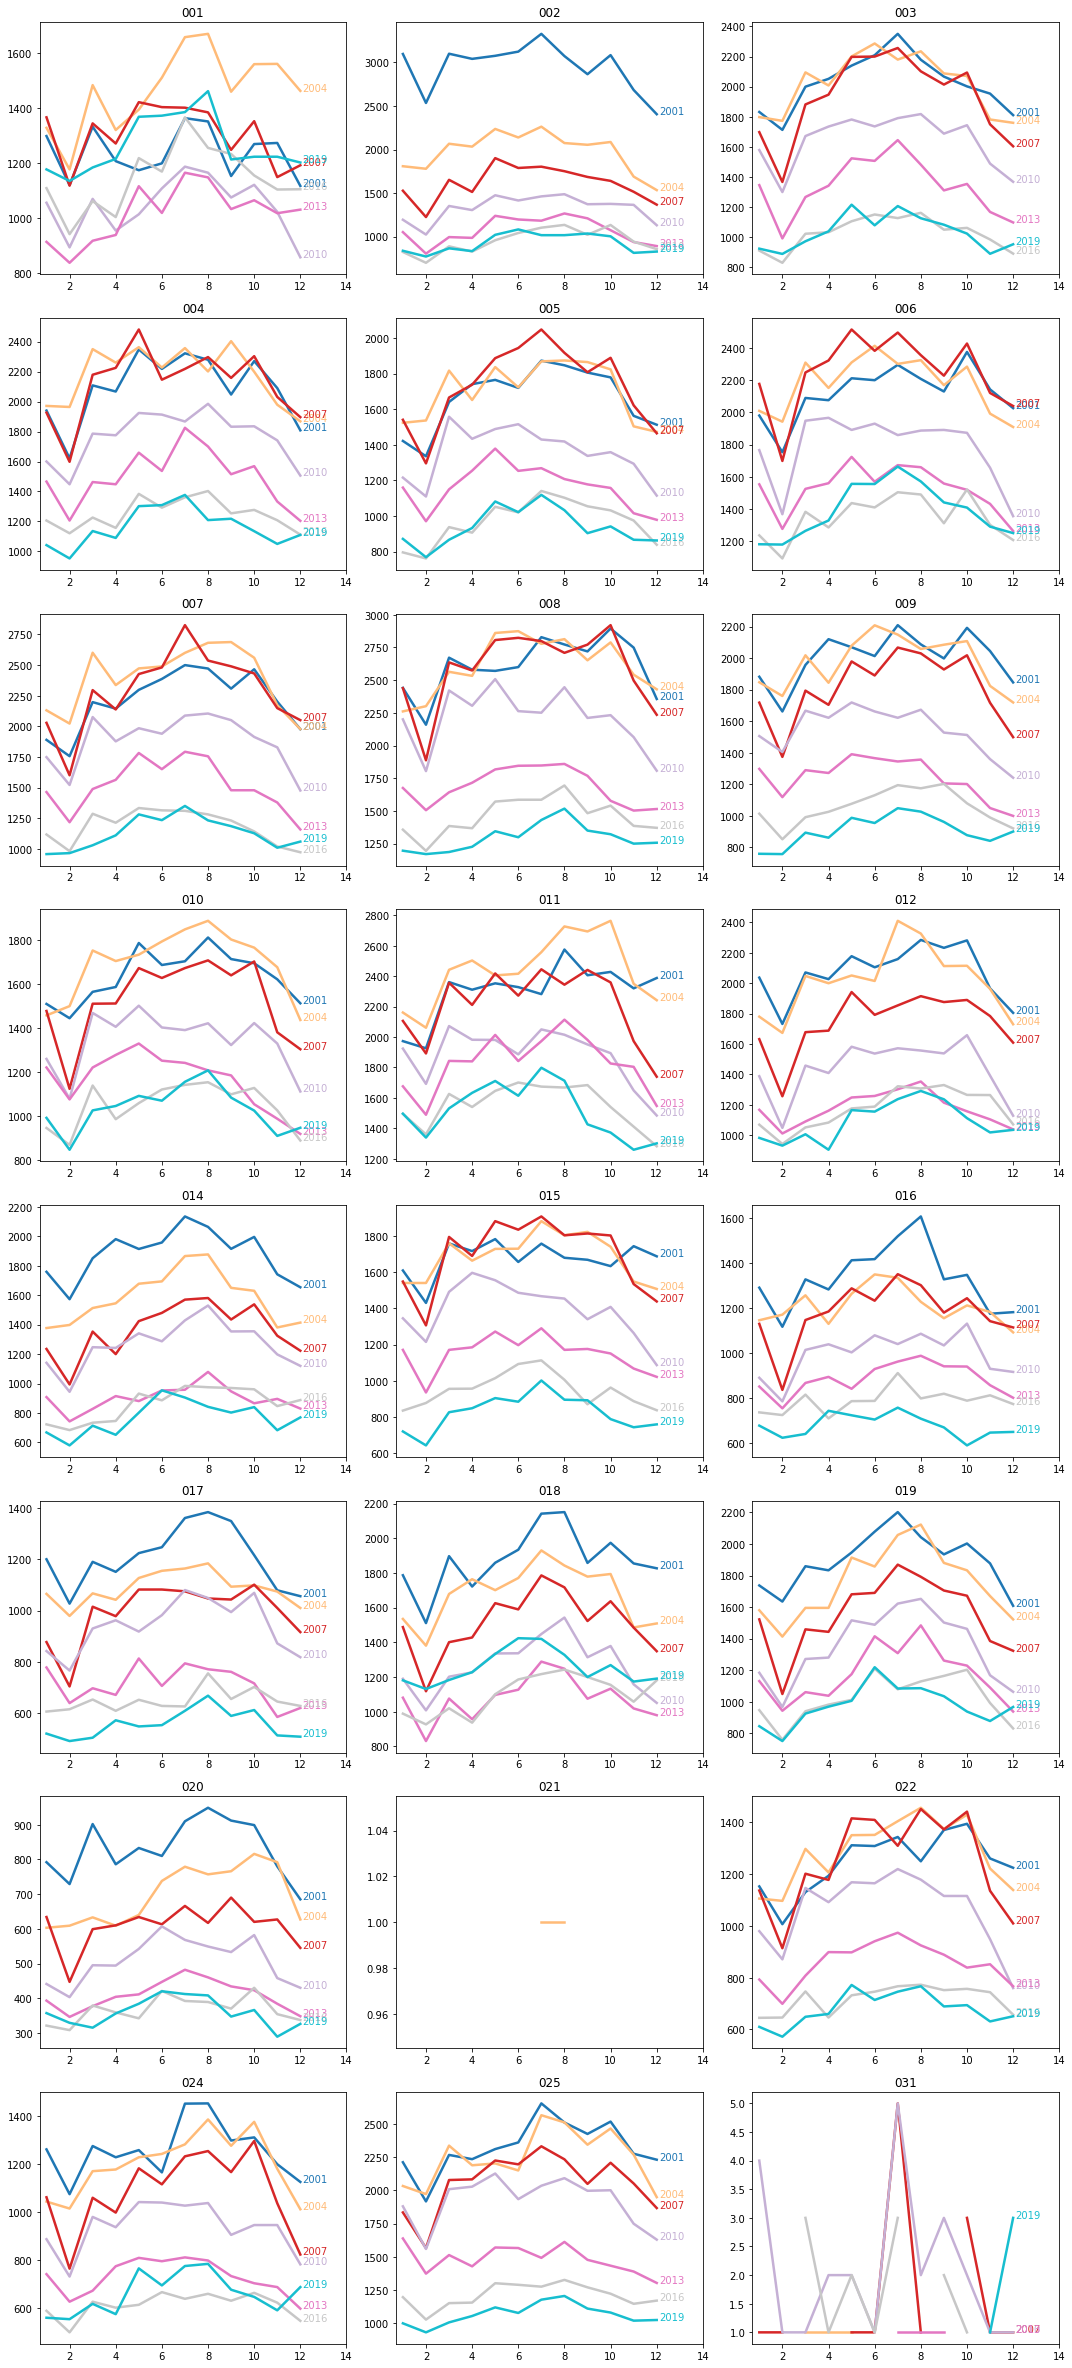

In [22]:
fig,ax = plt.subplots(8,3, sharex=False, sharey=False,figsize=(15,33))
col = 0
row = 0
init = True
for dist in df_monthly_dist.columns:
    if dist != "month": 
        col = col % 3
        if not init and col == 0:
            row = row + 1
        init = False
        
        for i,year in enumerate(np.arange(2001,2020,3)):
            _vals = df_monthly_dist[str(dist)][str(year)].values
            ax[row][col].set_xlim(.7, 14)
            ax[row][col].plot(np.arange(1,13), _vals, color=tableau_20[i*3],linewidth=2.5)
            _y = _vals[-1]
            ax[row][col].set_title(str(dist))
            ax[row][col].text(x=12.1,y=_y,s=str(year),color=tableau_20[i*3],fontsize=10)
        col += 1
plt.tight_layout()
plt.show()

We can see that most districts have less crime in the end and a top at the summer season

## Weekly crime trend
We will look into how the crime rate changes over the weekdays in this section. After looking into the pyspark.sql source code, we noticed that it has a bug where it starts each week by sundays. We will therefore shift all days by one below

In [23]:
weekly = df.groupBy("year","DayOfWeek").count().sort(F.col("year"))
weekly.show()

+----+---------+-----+
|year|DayOfWeek|count|
+----+---------+-----+
|2001|        5|69320|
|2001|        3|69019|
|2001|        2|70818|
|2001|        6|72531|
|2001|        1|65058|
|2001|        7|69451|
|2001|        4|69566|
|2002|        3|71247|
|2002|        2|68564|
|2002|        1|65367|
|2002|        4|69375|
|2002|        6|73330|
|2002|        7|70027|
|2002|        5|68852|
|2003|        7|67895|
|2003|        5|67648|
|2003|        6|70723|
|2003|        2|67581|
|2003|        4|70124|
|2003|        1|63450|
+----+---------+-----+
only showing top 20 rows



In [25]:
weekly_piv =(weekly\
             .groupBy("year")\
             .pivot("DayOfWeek")\
             .agg({"count":"max"})\
             .orderBy('year'))

#1=Sunday, 2=Monday,...
weekly_piv.show(5)

+----+-----+-----+-----+-----+-----+-----+-----+
|year|    1|    2|    3|    4|    5|    6|    7|
+----+-----+-----+-----+-----+-----+-----+-----+
|2001|65058|70818|69019|69566|69320|72531|69451|
|2002|65367|68564|71247|69375|68852|73330|70027|
|2003|63450|67581|68531|70124|67648|70723|67895|
|2004|62676|65668|67086|68492|68878|70699|65891|
|2005|60389|64116|65783|65354|64786|67945|65347|
+----+-----+-----+-----+-----+-----+-----+-----+
only showing top 5 rows



In [26]:
df_weekly = weekly_piv.toPandas().set_index('year')
df_weekly.head()

,1,2,3,4,5,6,7
year,,,,,,,
2001,65058,70818,69019,69566,69320,72531,69451
2002,65367,68564,71247,69375,68852,73330,70027
2003,63450,67581,68531,70124,67648,70723,67895
2004,62676,65668,67086,68492,68878,70699,65891
2005,60389,64116,65783,65354,64786,67945,65347


/home/ubuntu/anaconda3/envs/dat500/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<Figure size 432x288 with 0 Axes>

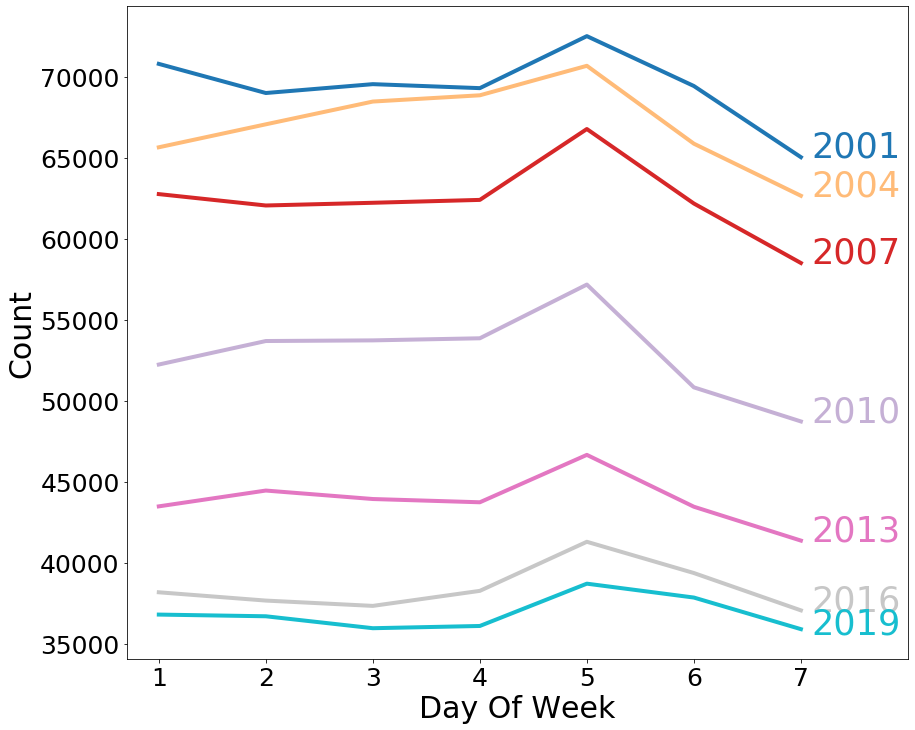

In [34]:
plt.clf()
plt.figure(figsize=(14, 12)) 
plt.xticks(np.arange(1,8))
  
ax = plt.subplot(111)    
plt.xlim(.7, 8) 

i=0
for idx,r in df_weekly.iterrows():
    if i%3==0 and int(idx) != 2020:    
        _d = list(r.values)
        _d.append(_d.pop(0)) #Shift by 1
        plt.plot(np.arange(1,8), _d, color=tableau_20[i],linewidth=4)
        _y = int(_d[6])
        if int(idx) == 2019:
            _y = _y - 300
        plt.text(x=7.1,y=_y,s=str(idx),color=tableau_20[i],fontsize=35)
    i+=1

plt.xlabel('Day Of Week', fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('weekly_trend.png')
plt.show()

#### Weekly count per district

In [35]:
weekly_dist = (df\
            .groupBy("DayOfWeek","year","District")\
            .count()\
            .groupBy("year","DayOfWeek")\
            .pivot("District")\
            .agg({'count':'max'})\
            .drop("District","null")\
            .orderBy('year','DayOfWeek'))

In [36]:
df_weekly_dist = weekly_dist.toPandas().set_index('year')
df_weekly_dist.head()

,DayOfWeek,001,002,003,004,005,006,007,008,009,...,016,017,018,019,020,021,022,024,025,031
year,,,,,,,,,,,,,,,,,,,,,
2001,1,1433,4657,3184,3346,2656,3264,3649,4227,3325,...,2236,1966,3060,3030,1316,NaN,1983,2117,3896,NaN
2001,2,2368,5218,3580,3673,2999,3666,3768,4675,3517,...,2241,2060,3019,3256,1531,NaN,2266,2294,4103,NaN
2001,3,2264,5165,3490,3660,2831,3748,3899,4425,3311,...,2231,2032,2994,3163,1385,NaN,2225,2093,3935,NaN
2001,4,2217,5260,3547,3584,2913,3738,3800,4323,3501,...,2284,2028,3107,3267,1420,NaN,2091,2149,3899,NaN
2001,5,2318,5045,3521,3635,2855,3802,3789,4559,3411,...,2250,2068,3163,3224,1445,NaN,2120,2116,3864,NaN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


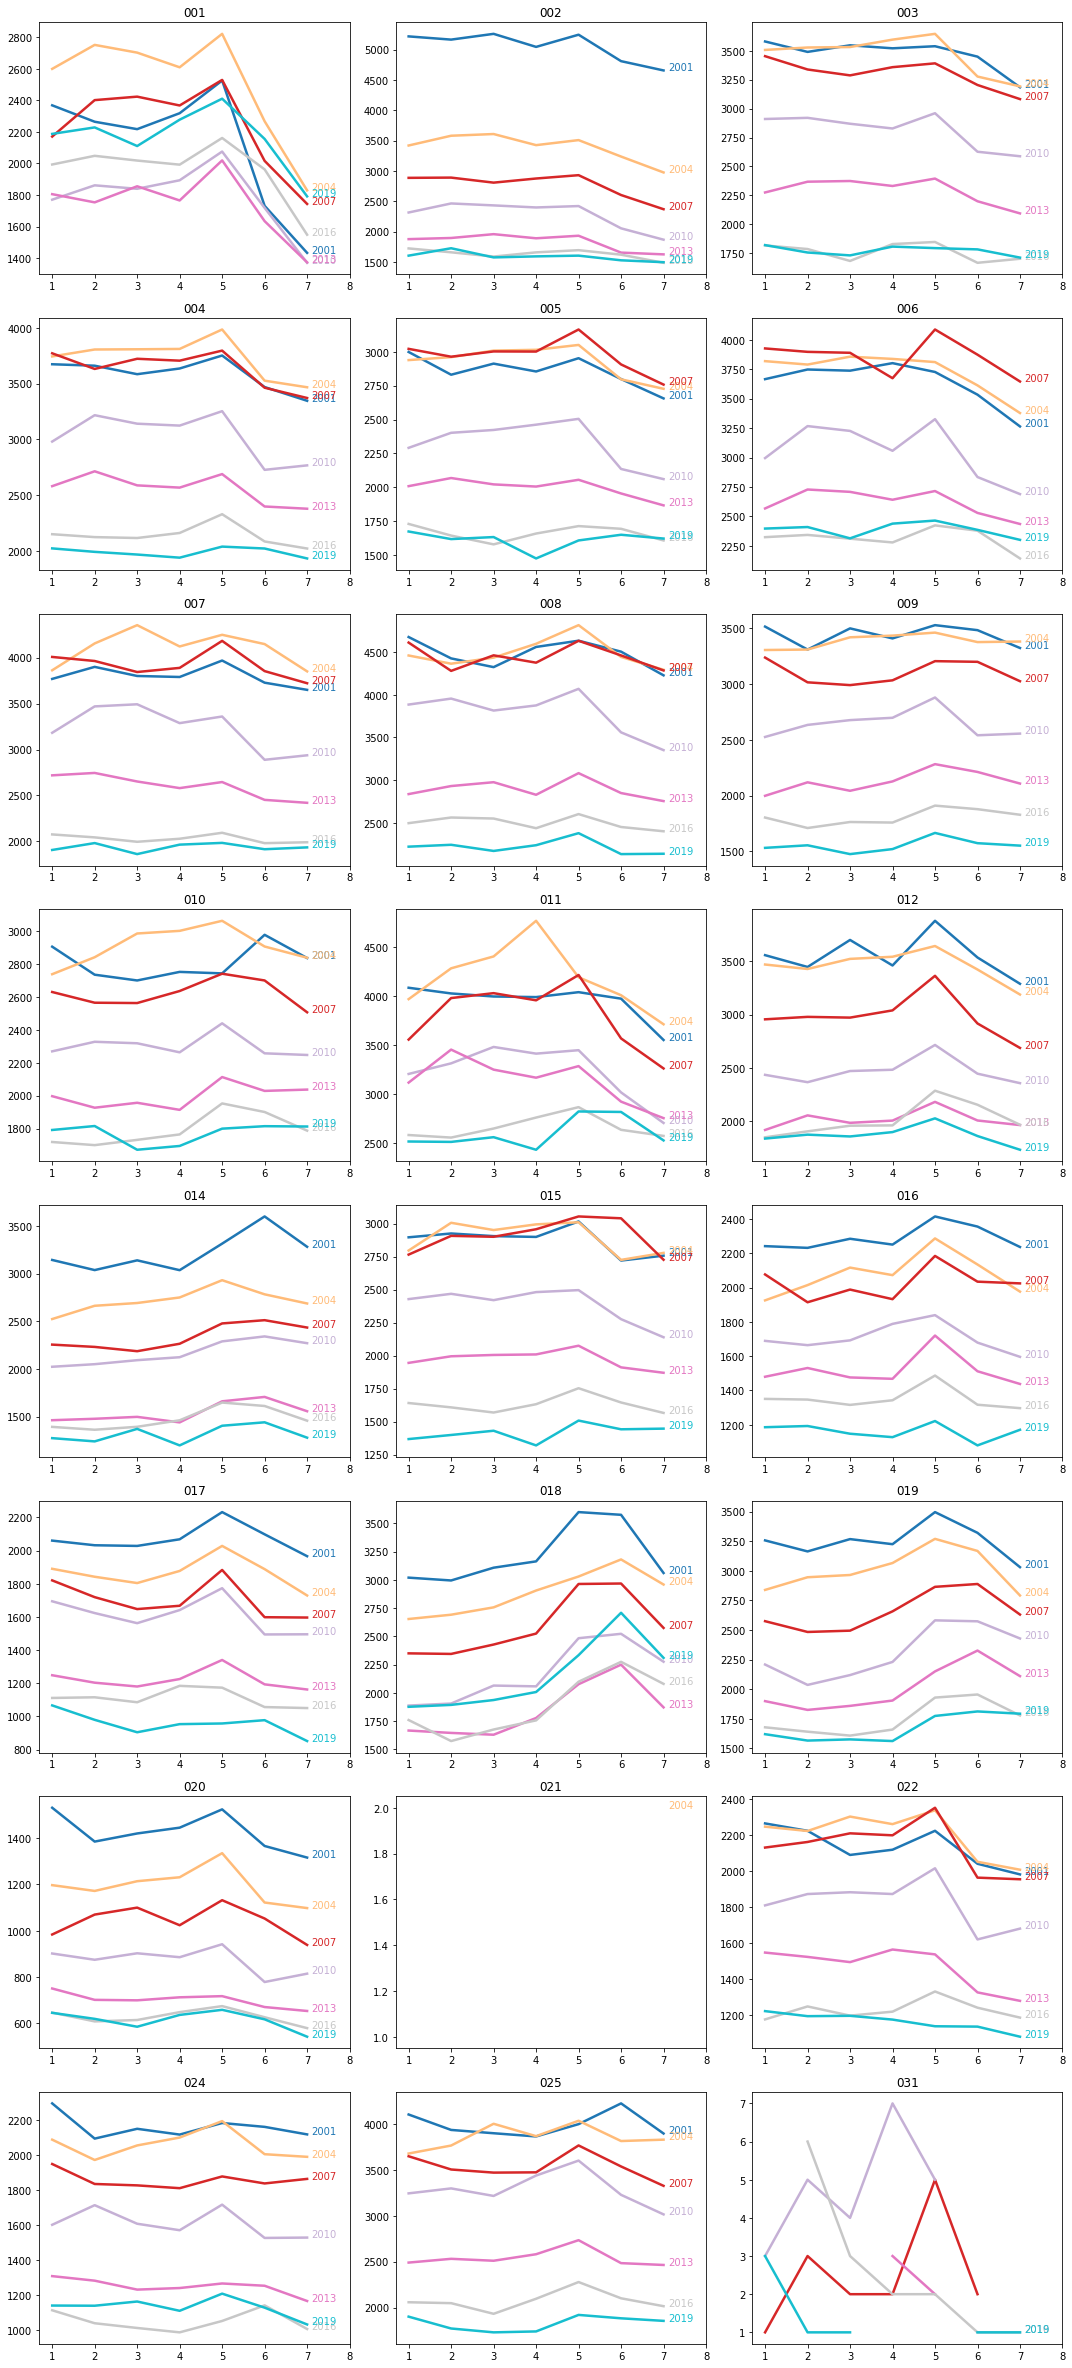

In [38]:
fig,ax = plt.subplots(8,3, sharex=False, sharey=False,figsize=(15,33))
col = 0
row = 0
init = True
for dist in df_weekly_dist.columns:
    if dist != "DayOfWeek": 
        col = col % 3
        if not init and col == 0:
            row = row + 1
        init = False
        
        for i,year in enumerate(np.arange(2001,2020,3)):
            _vals = list(df_weekly_dist[str(dist)][str(year)].values)
            _vals.append(_vals.pop(0)) #Shift by 1
            ax[row][col].set_xlim(.7, 8)
            ax[row][col].plot(np.arange(1,8), _vals, color=tableau_20[i*3],linewidth=2.5)
            _y = _vals[-1]
            ax[row][col].set_title(str(dist))
            ax[row][col].text(x=7.1,y=_y,s=str(year),color=tableau_20[i*3],fontsize=10)
        col += 1
plt.tight_layout()
plt.show()

Most districts seems to have most crime on fridays, however district 018 has most on saturdays (more nightclubs and bars?). Also district 001 has a clear drop after fridays (business area?)

## Sub daily crime trend

We will look into when crime occurs during a day in this section

In [231]:
sub_daily = df.groupBy("year","Hour").count().sort(F.col("year"))
sub_daily.show(5)

+----+----+-----+
|year|Hour|count|
+----+----+-----+
|2001|   6| 6808|
|2001|  14|24294|
|2001|   3|10347|
|2001|   2|13111|
|2001|  11|20891|
+----+----+-----+
only showing top 5 rows



In [232]:
hourly_piv =(sub_daily\
             .groupBy("year")\
             .pivot("Hour")\
             .agg({"count":"max"})\
             .orderBy('year'))

+----+-----+-----+-----+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|year|    0|    1|    2|    3|   4|   5|   6|    7|    8|    9|   10|   11|   12|   13|   14|   15|   16|   17|   18|   19|   20|   21|   22|   23|
+----+-----+-----+-----+-----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+
|2001|25113|15986|13111|10347|7927|6316|6808|10067|15407|18952|19955|20891|26930|23014|24294|25407|24776|25816|28322|28285|28621|28146|27973|23299|
|2002|27481|15716|13274|10536|7932|6391|7183|10592|15927|19591|20157|20800|26783|22758|24762|24834|23643|24833|27699|28059|28561|28140|27954|23156|
|2003|27574|15085|12681|10149|7469|6174|7067|10412|15640|18503|18775|20252|26896|22358|24359|24905|23771|24747|26203|27707|28117|27529|27088|22491|
|2004|26976|15169|12678| 9896|7466|6191|7294|10382|15259|18850|18702|20207|27180|22801|24505|24568|22869|23078|2

In [233]:
df_hourly = hourly_piv.toPandas().set_index('year')
df_hourly.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
year,,,,,,,,,,,,,,,,,,,,,
2001,25113,15986,13111,10347,7927,6316,6808,10067,15407,18952,...,24294,25407,24776,25816,28322,28285,28621,28146,27973,23299
2002,27481,15716,13274,10536,7932,6391,7183,10592,15927,19591,...,24762,24834,23643,24833,27699,28059,28561,28140,27954,23156
2003,27574,15085,12681,10149,7469,6174,7067,10412,15640,18503,...,24359,24905,23771,24747,26203,27707,28117,27529,27088,22491
2004,26976,15169,12678,9896,7466,6191,7294,10382,15259,18850,...,24505,24568,22869,23078,24942,26437,27472,27247,26614,22607
2005,26195,15117,12111,9777,7356,5990,6888,9941,14874,18501,...,23105,23691,21810,22061,23942,25153,26464,26287,25903,22068


/home/ubuntu/anaconda3/envs/dat500/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<Figure size 432x288 with 0 Axes>

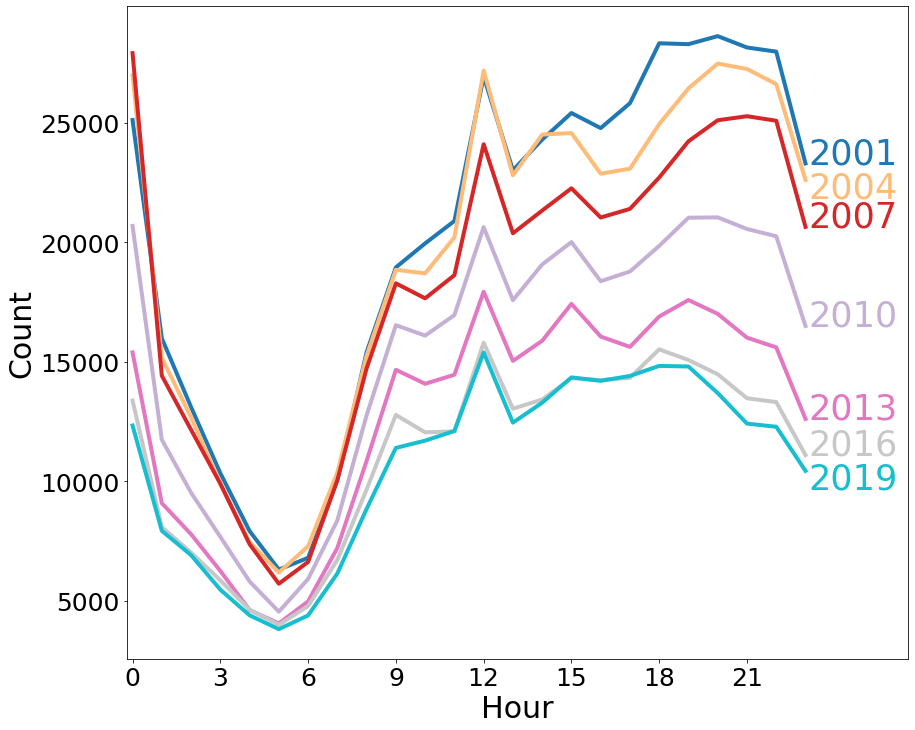

In [248]:
plt.clf()
plt.figure(figsize=(14, 12)) 
plt.xticks(np.arange(0,23,3))
  
ax = plt.subplot(111)    
plt.xlim(-.2, 26.5) 

i=0
for idx,r in df_hourly.iterrows():
    if i%3==0 and int(idx) != 2020:    
        plt.plot(np.arange(0,24), r.values, color=tableau_20[i],linewidth=4)
        _y = int(r[23])
        if int(idx) in [2004,2019]:
            _y = _y - 750
        plt.text(x=23.1,y=_y,s=str(idx),color=tableau_20[i],fontsize=35)
    i+=1

plt.xlabel('Hour', fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('hourly_trend.png')
plt.show()

Big spike 12 (lunch)

#### Sub daily count per district

In [279]:
hourly_dist = (df\
            .groupBy("Hour","District")\
            .count()\
            .groupBy("Hour")\
            .pivot("District")\
            .agg({'count':'max'})\
            .drop("District","null")\
            .orderBy("Hour"))

In [280]:
df_hourly_dist = hourly_dist.toPandas().set_index('Hour')
df_hourly_dist.head()

,001,002,003,004,005,006,007,008,009,010,...,016,017,018,019,020,021,022,024,025,031
Hour,,,,,,,,,,,,,,,,,,,,,
0,9571,16260,18146,22349,16731,22740,22127,27974,19733,16141,...,15360,12421,17925,20891,7545,1.0,13525,13095,23259,13.0
1,4923,9257,11435,12797,9455,13482,14039,14825,11065,9766,...,6890,6500,12675,11772,3562,NaN,6589,6385,13392,3.0
2,4195,7311,9160,10477,7521,10773,11302,12756,9255,7998,...,5871,5870,12189,10711,3112,NaN,5518,5244,10933,3.0
3,3423,5777,7482,8261,6131,8874,9211,10496,7324,6392,...,4623,4493,10456,8282,2545,NaN,4307,4272,9112,NaN
4,2838,4542,5711,6668,4680,6956,6777,8332,5645,4977,...,3700,3527,6694,5880,1967,NaN,3216,3392,6595,5.0


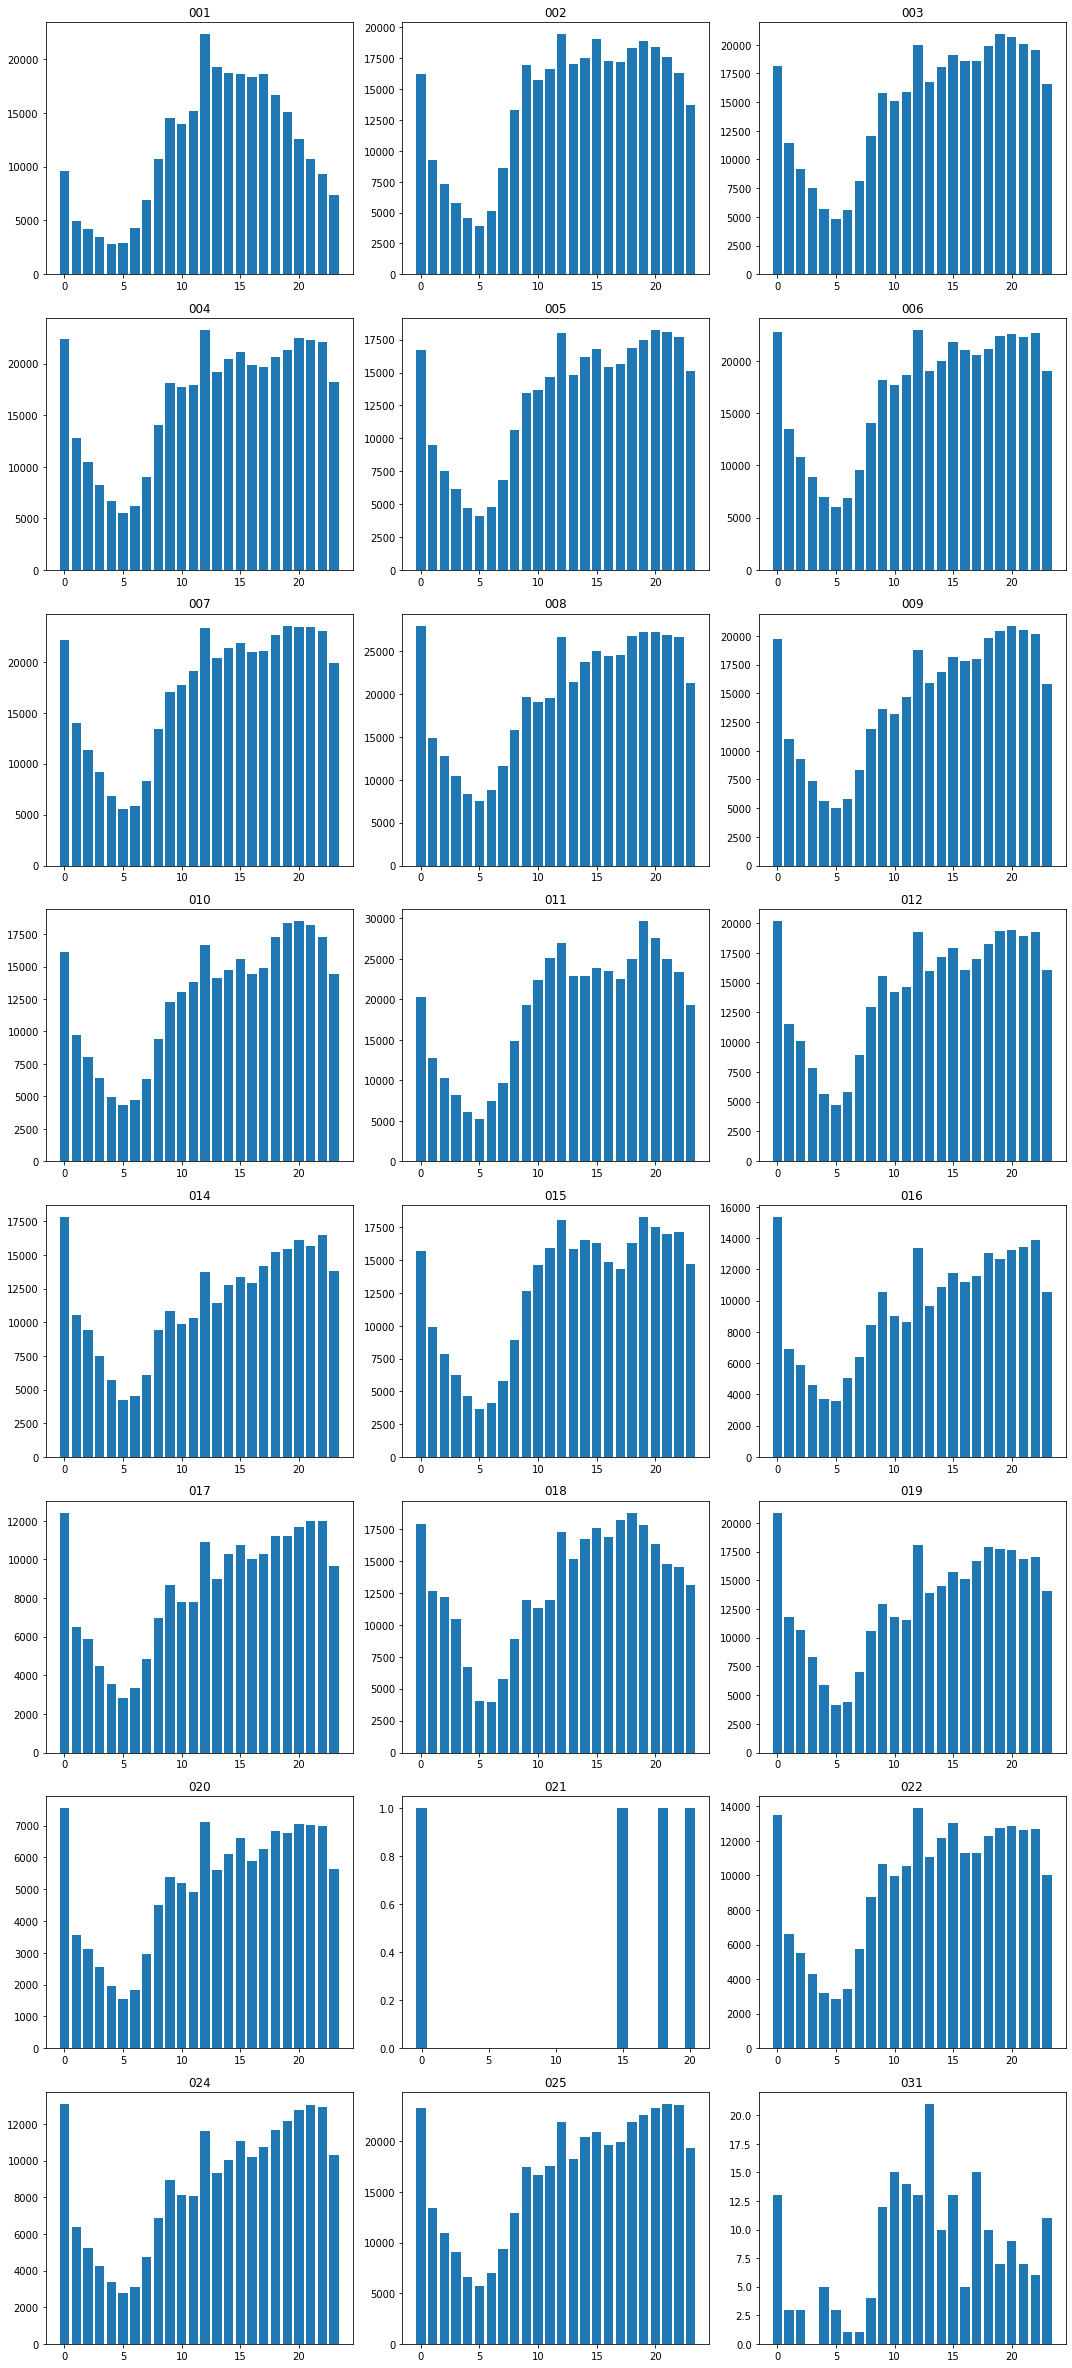

In [282]:
fig,ax = plt.subplots(8,3, sharex=False, sharey=False,figsize=(15,33))
col = 0
row = 0
init = True
for dist in df_hourly_dist.columns:
    if dist != "Hour": 
        col = col % 3
        if not init and col == 0:
            row = row + 1
        init = False
        _vals = df_hourly_dist[str(dist)].values
        ax[row][col].bar(np.arange(0,24), _vals)
        ax[row][col].set_title(str(dist))

        col += 1
plt.tight_layout()
plt.show()

We can see that most districts follows the same pattern

## Day of month crime trend

We will see if there is some common pattern in crime each month

In [7]:
day_of_month = df.groupBy("year","DayOfMonth").count().sort(F.col("year"))
dom_piv =(day_of_month\
             .groupBy("year")\
             .pivot("DayOfMonth")\
             .agg({"count":"max"})\
             .orderBy('year'))

df_dom = dom_piv.toPandas().set_index('year')
df_dom.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
year,,,,,,,,,,,,,,,,,,,,,
2001,18951,16009,15864,16036,15941,16077,16331,16192,16012,16124,...,15438,15617,15263,14757,15457,15988,15698,14595,14686,9301.0
2002,19042,15667,14966,15385,15630,15984,15557,15940,16309,16231,...,15583,15973,15684,15429,15684,15778,15589,14725,14856,9186.0
2003,18483,15312,15549,15080,15285,15834,15798,15407,15289,16068,...,15269,15568,15311,15143,14964,15190,15397,14316,14386,8998.0
2004,17970,15327,15205,14902,15370,15624,15119,15488,15448,15948,...,14854,15629,15123,14301,14898,15336,15320,15520,13748,8990.0
2005,17681,14674,14770,14956,15150,14552,14912,14865,14752,15279,...,14254,14326,13989,14891,14735,14472,14720,13995,13615,8799.0


/home/ubuntu/anaconda3/envs/dat500/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


<Figure size 432x288 with 0 Axes>

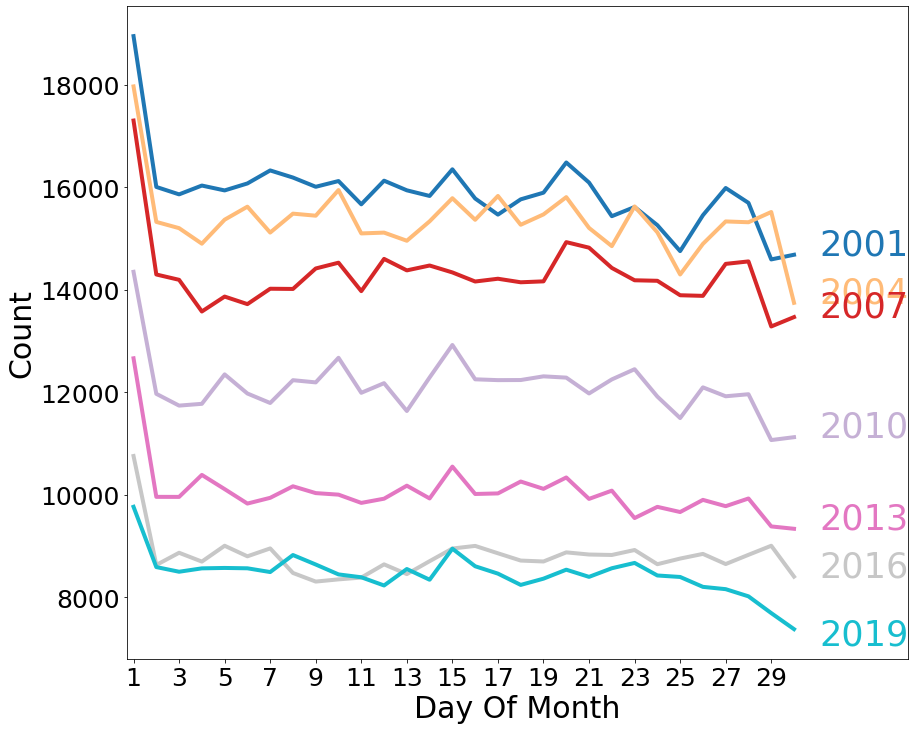

In [14]:
plt.clf()
plt.figure(figsize=(14, 12)) 
plt.xticks(np.arange(1,31,2))
  
ax = plt.subplot(111)    
plt.xlim(.7, 35) 

i=0
for idx,r in df_dom.iterrows():
    if i%3==0 and int(idx) != 2020:    
        plt.plot(np.arange(1,31), r.values[:30], color=tableau_20[i],linewidth=4)
        _y = int(r[29])
        if int(idx) == 2019:
            _y = _y - 300
        plt.text(x=31.1,y=_y,s=str(idx),color=tableau_20[i],fontsize=35)
    i+=1

plt.xlabel('Day Of Month', fontsize=30)
plt.ylabel('Count',fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.savefig('dayofmonth_trend.png')
plt.show()

We can see that most crime occur during the first day of each month (Due to january 1st spike?). There is no pattern in the rest of the month (and the end of the month is slighly lower since february has fewer dates).